In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [2]:
with open('train_config.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [3]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [4]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date,
               max_evals = 1000, data_source = None, 
               mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = train_config['model_class']
       
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'Train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'Train2'))
            
    model_params['model_parameters'] = finalResults['model_parameters']
    
    return params, metrics, model_params

In [8]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [9]:
def plot(model_params, run_day, forecast_start_date, forecast_end_date, 
         actual_start_date, plot_name = 'default.png'):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    pdjson = ForecastingModule.from_config(evalConfig)
    pd_df = pd.read_json(pdjson)
    pd_df = pd_df.set_index('prediction_type')
    pd_df = pd_df.transpose()
    pd_df = pd_df.reset_index()
    pd_df = pd_df[5:]
    pd_df['index'] = pd.to_datetime(pd_df['index'])
    pd_df = pd_df.sort_values(by=['index'])

    actual = DataFetcherModule.get_observations_for_region(model_params['region_type'], model_params['region'])
    actual = actual.set_index('observation')
    actual = actual.transpose()
    actual = actual.reset_index()
    start = actual.index[actual['index'] == actual_start_date].tolist()[0]
    actual = actual[start : ]
    actual['index'] = pd.to_datetime(actual['index'])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title(model_params['region'])
    ax.plot(actual['index'], actual['confirmed'], color='green', label="observed")
    ax.plot(pd_df['index'], pd_df['confirmed_mean'], color='orange', label="predicted")
    plt.xticks(rotation=90)
    ax.set_ylim(ymin=0)
    ax.legend()
    fig.tight_layout()
    
    plt.savefig(plot_name)

## Train eval for specific regions

In [5]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '5/5/20'
train1_end_date = '5/11/20'
train2_start_date = '5/12/20'
train2_end_date = '5/18/20'
test_start_date = '5/12/20'
test_end_date = '5/18/20'
run_day = '5/11/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 1000,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

t = 7.90                                                
t = 7.90                                                
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                         
t = 7.90                                                                          
t = 7.90                                                                          
t = 7.90                                                        

t = 7.90                                                                           
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                          

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                                            
t = 7.90                                                         

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                           
t = 7.90                                                                    

In [10]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIHRD',
 'model_parameters': {'incubation_period': 5,
  'F_hospitalization': 0.04,
  'F_icu': 0.05,
  'F_fatalities': 0.08,
  'EbyCRatio': 0.5298460301415714,
  'IbyCRatio': 0.8171503211428431,
  'infectious_period': 9.674462213654094,
  'r0': 0.5986964569608118,
  'LatentEbyCRatio': {'5/11/20': 0.5298460301415714,
   '5/18/20': 0.3242396531931018},
  'LatentIbyCRatio': {'5/11/20': 0.8171503211428431,
   '5/18/20': 0.1621341108769617},
  'MAPE': 35.50990083387747}}

In [11]:
metrics

{'Train1MAPE': 2.9003463651124375,
 'Train1RMLSE': 0.04932364350646826,
 'Train1_EbyCRatio': 0.5018055880494646,
 'Train1_IbyCRatio': 0.8871622908422646,
 'Train1_infectious_period': 8.898696237587215,
 'Train1_r0': 0.5000015335189376,
 'Train1_LatentEbyCRatio_5/4/20': 0.5018055880494646,
 'Train1_LatentEbyCRatio_5/11/20': 0.26788885908154275,
 'Train1_LatentIbyCRatio_5/4/20': 0.8871622908422646,
 'Train1_LatentIbyCRatio_5/11/20': 0.16470371345982668,
 'TestMAPE': 9.733648905745053,
 'TestRMLSE': 0.10383677537305558,
 'Train2MAPE': 35.50990083387747,
 'Train2RMLSE': 0.32446369181369844,
 'Train2_EbyCRatio': 0.5298460301415714,
 'Train2_IbyCRatio': 0.8171503211428431,
 'Train2_infectious_period': 9.674462213654094,
 'Train2_r0': 0.5986964569608118,
 'Train2_LatentEbyCRatio_5/11/20': 0.5298460301415714,
 'Train2_LatentEbyCRatio_5/18/20': 0.3242396531931018,
 'Train2_LatentIbyCRatio_5/11/20': 0.8171503211428431,
 'Train2_LatentIbyCRatio_5/18/20': 0.1621341108769617}

## Forecast

In [12]:
run_day = '5/11/20'
forecast_start_date = '5/12/20'
forecast_end_date = '5/30/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

t = 19.90


In [17]:
forecast_df[['index', 'icu_mean', 'recovered_mean', 'deceased_mean', 'confirmed_mean', 'hospitalized_mean']]

prediction_type,index,icu_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean
0,5/12/20,326.294013,4588.045452,398.960474,11512.886191,6525.880265
1,5/13/20,255.791686,6738.066056,585.918787,12439.818562,5115.833719
2,5/14/20,209.622358,8455.898490,735.295521,13383.641179,4192.447168
3,5/15/20,179.561916,9891.261674,860.109711,14342.609705,3591.238320
4,5/16/20,160.200508,11143.474996,968.997826,15316.482972,3204.010150
5,5/17/20,147.919302,12278.420384,1067.688729,16304.495151,2958.386038
6,5/18/20,140.289189,13339.579597,1159.963443,17305.326818,2805.783777
7,5/19/20,135.674382,14355.371735,1248.293194,18317.152578,2713.487649
8,5/20/20,133.065890,15344.294619,1334.286489,19339.898903,2661.317795
9,5/21/20,131.817948,16318.857878,1419.031120,20374.247966,2636.358968


### Forecast Plot

t = 19.90


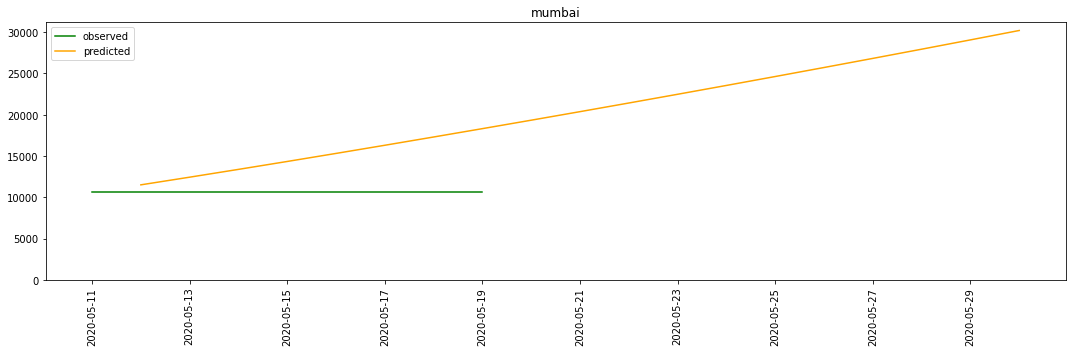

In [19]:
actual_start_date = '5/11/20'
plot(model_params, run_day, forecast_start_date, forecast_end_date, actual_start_date, plot_name = 'default.png')